In [4]:
def stock_ml_pipeline(ticker, start_date="2020-01-01"):
    import yfinance as yf
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import (
        accuracy_score, roc_auc_score,
        classification_report, ConfusionMatrixDisplay, RocCurveDisplay
    )
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from xgboost import XGBClassifier
    
    print(f"🔄 Fetching data for {ticker} ...")
    data = yf.download(ticker, start=start_date)['Close']
    returns = data.pct_change()
    
    # Feature engineering
    df = pd.DataFrame(index=data.index)
    df['close'] = data
    df['return'] = returns
    df['ma5'] = data.rolling(5).mean()
    df['ma10'] = data.rolling(10).mean()
    df['volatility'] = returns.rolling(5).std()
    
    # Create target (next day up/down)
    df = df.dropna()
    df['target'] = (df['return'].shift(-1) > 0).astype(int)
    df = df.dropna()
    
    features = ['return','ma5','ma10','volatility']
    X = df[features]
    y = df['target']
    
    # Train/test split
    split = int(len(X)*0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(probability=True),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, use_label_encoder=False, eval_metric="logloss"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Naive Bayes": GaussianNB()
    }
    
    # Train & evaluate
    results = {}
    no_scale_models = ["Random Forest", "XGBoost", "KNN", "Naive Bayes"]
    
    for name, model in models.items():
        if name in no_scale_models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:,1]
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)[:,1]
        
        acc = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_prob)
        results[name] = (acc, roc)
    
    # Show comparison table
    compare_df = pd.DataFrame(results, index=["Accuracy","ROC-AUC"]).T.sort_values("ROC-AUC", ascending=False)
    print("\n📊 Model Comparison:")
    print(compare_df)
    
    # ROC curves for all models
    fig, ax = plt.subplots(figsize=(8,6))
    for name, model in models.items():
        if name in no_scale_models:
            y_prob = model.predict_proba(X_test)[:,1]
        else:
            y_prob = model.predict_proba(X_test_scaled)[:,1]
        RocCurveDisplay.from_predictions(y_test, y_prob, name=name, ax=ax)
    plt.title(f"ROC Curves for {ticker}")
    plt.show()
    
    # Best model evaluation
    best_model_name = max(results, key=lambda x: results[x][1])
    print(f"\n✅ Best Model: {best_model_name}")
    best_model = models[best_model_name]
    
    if best_model_name in no_scale_models:
        y_best_pred = best_model.predict(X_test)
    else:
        y_best_pred = best_model.predict(X_test_scaled)
    
    print("\n=== Classification Report for Best Model ===")
    print(classification_report(y_test, y_best_pred, target_names=["Down","Up"]))
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_best_pred)
    plt.title(f"Confusion Matrix for {best_model_name} ({ticker})")
    plt.show()
    
    # Feature importance for interpretable models
    print("\n📈 Feature Importance:")
    tree_models = ["Random Forest", "XGBoost"]
    for name, model in models.items():
        if name in tree_models:
            pd.Series(model.feature_importances_, index=features).sort_values().plot(kind='barh', title=f"{name} Feature Importance")
            plt.show()
        elif name == "Logistic Regression":
            pd.Series(model.coef_[0], index=features).sort_values().plot(kind='barh', title=f"{name} Coefficients")
            plt.show()
        else:
            pass
    
    return compare_df, best_model_name


🔄 Fetching data for PLTR ...


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_27624\3201791648.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Liam Sydney\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:18:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:
                     Accuracy   ROC-AUC
SVM                  0.414226  0.566871
Random Forest        0.435146  0.515683
Naive Bayes          0.422594  0.513741
KNN                  0.405858  0.513094
Logistic Regression  0.418410  0.496043
XGBoost              0.422594  0.482734


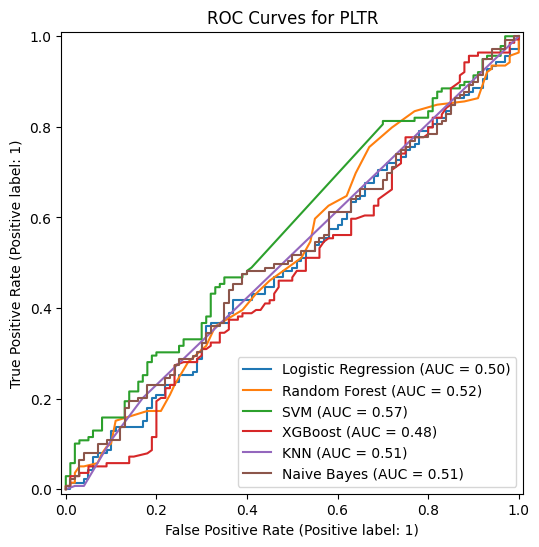


✅ Best Model: SVM

=== Classification Report for Best Model ===
              precision    recall  f1-score   support

        Down       0.41      0.93      0.57       100
          Up       0.46      0.04      0.08       139

    accuracy                           0.41       239
   macro avg       0.44      0.49      0.32       239
weighted avg       0.44      0.41      0.28       239



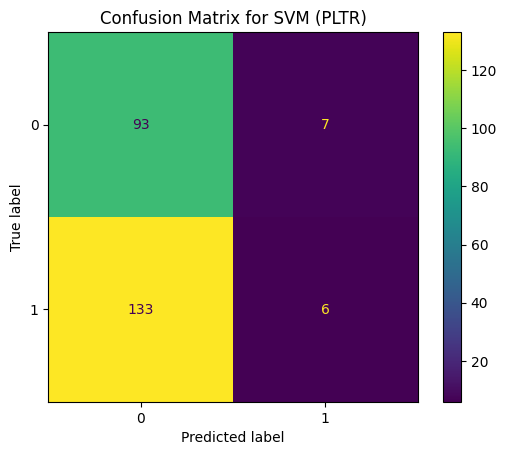


📈 Feature Importance:


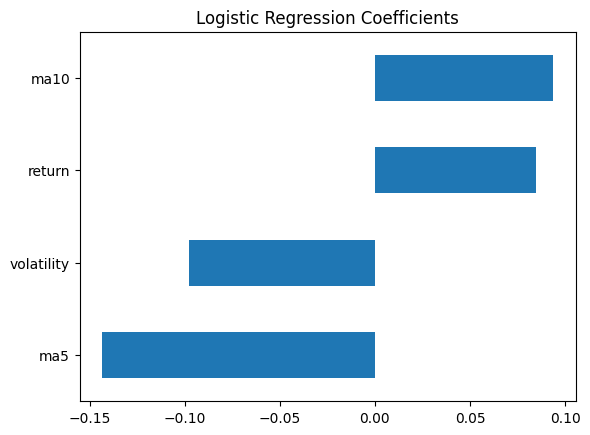

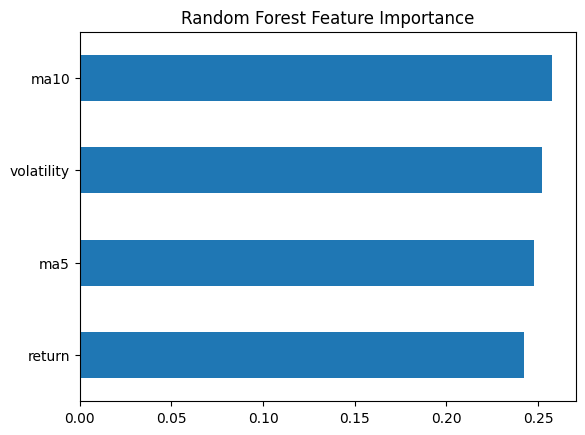

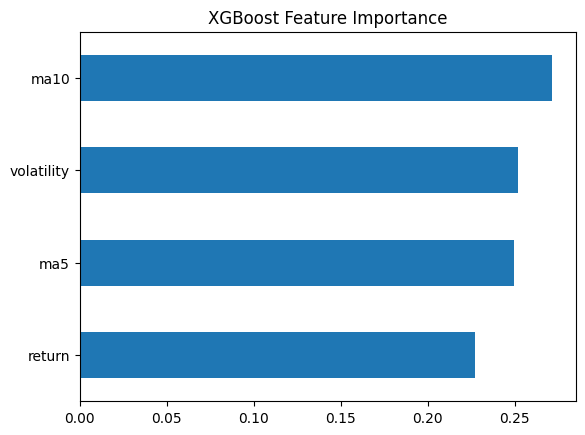

In [5]:
compare_df, best_model = stock_ml_pipeline("PLTR")


In [10]:
def multi_stock_ml_comparison(stocks, start_date="2020-01-01"):
    import pandas as pd
    summary = []
    
    for ticker in stocks:
        print("\n" + "="*50)
        print(f"🚀 Running ML pipeline for {ticker}")
        compare_df, best_model_name = stock_ml_pipeline(ticker, start_date=start_date)
        
        # Get best model's metrics
        best_acc = compare_df.loc[best_model_name, "Accuracy"]
        best_roc = compare_df.loc[best_model_name, "ROC-AUC"]
        
        summary.append({
            "Ticker": ticker,
            "Best Model": best_model_name,
            "Best Accuracy": round(best_acc,3),
            "Best ROC-AUC": round(best_roc,3)
        })
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary)
    print("\n📊 Overall Summary Across Stocks:")
    print(summary_df)
    
    # Sort by ROC-AUC (most predictable stock at top)
    return summary_df.sort_values("Best ROC-AUC", ascending=False)



🚀 Running ML pipeline for PLTR
🔄 Fetching data for PLTR ...


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_27624\3201791648.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Liam Sydney\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:23:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:
                     Accuracy   ROC-AUC
SVM                  0.414226  0.567518
Random Forest        0.435146  0.515683
Naive Bayes          0.422594  0.513741
KNN                  0.405858  0.513094
Logistic Regression  0.418410  0.496043
XGBoost              0.422594  0.482590


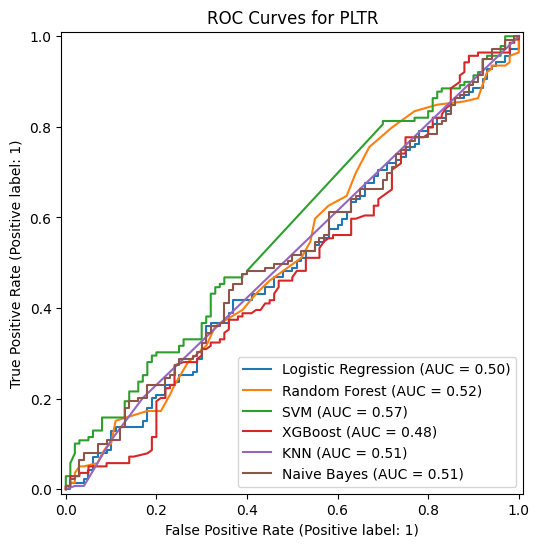


✅ Best Model: SVM

=== Classification Report for Best Model ===
              precision    recall  f1-score   support

        Down       0.41      0.93      0.57       100
          Up       0.46      0.04      0.08       139

    accuracy                           0.41       239
   macro avg       0.44      0.49      0.32       239
weighted avg       0.44      0.41      0.28       239



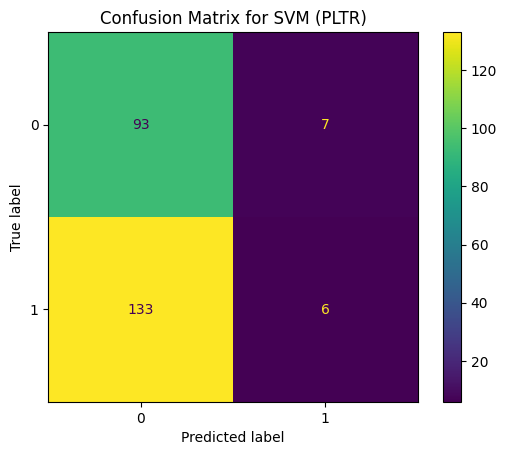


📈 Feature Importance:


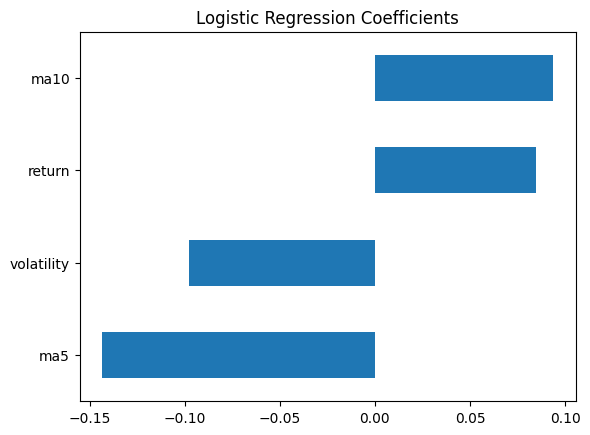

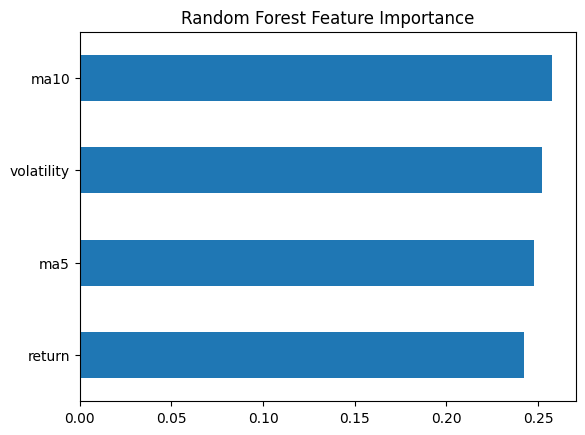

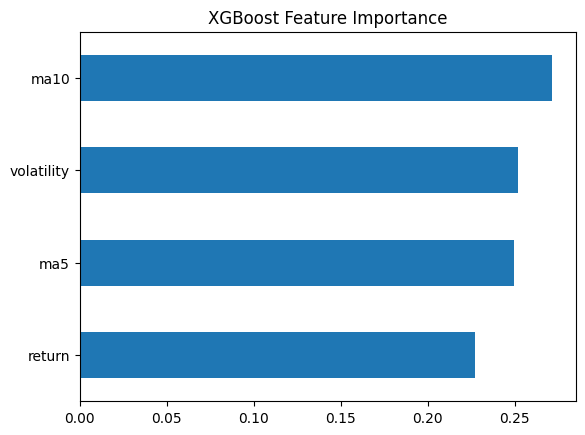


🚀 Running ML pipeline for SHOP
🔄 Fetching data for SHOP ...


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_27624\3201791648.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Liam Sydney\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:23:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:
                     Accuracy   ROC-AUC
Naive Bayes          0.545126  0.537542
KNN                  0.552347  0.537124
Logistic Regression  0.537906  0.534670
SVM                  0.519856  0.534618
XGBoost              0.523466  0.530963
Random Forest        0.512635  0.527151


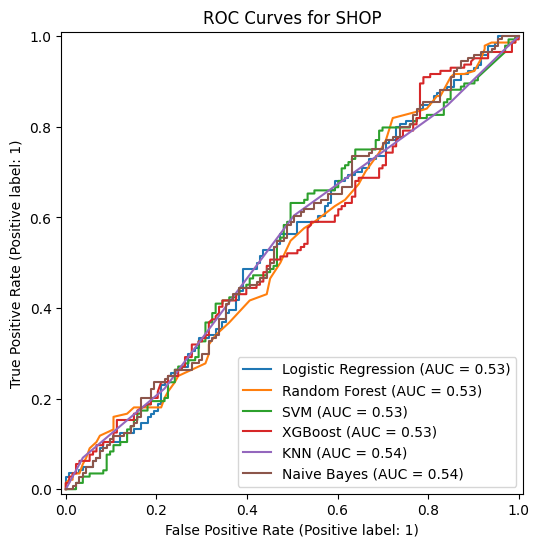


✅ Best Model: Naive Bayes

=== Classification Report for Best Model ===
              precision    recall  f1-score   support

        Down       0.57      0.21      0.31       133
          Up       0.54      0.85      0.66       144

    accuracy                           0.55       277
   macro avg       0.56      0.53      0.48       277
weighted avg       0.55      0.55      0.49       277



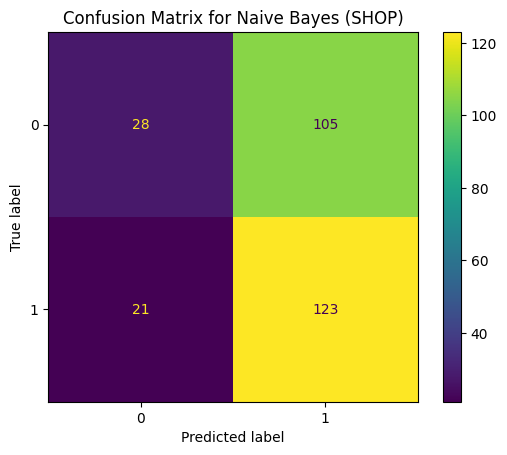


📈 Feature Importance:


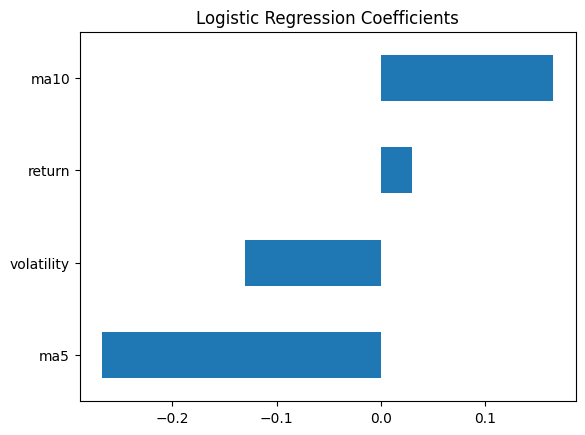

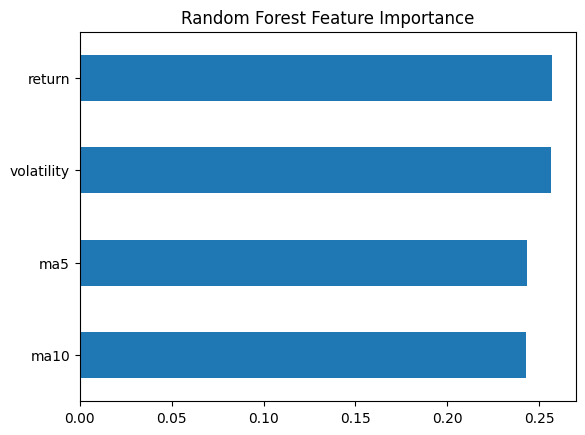

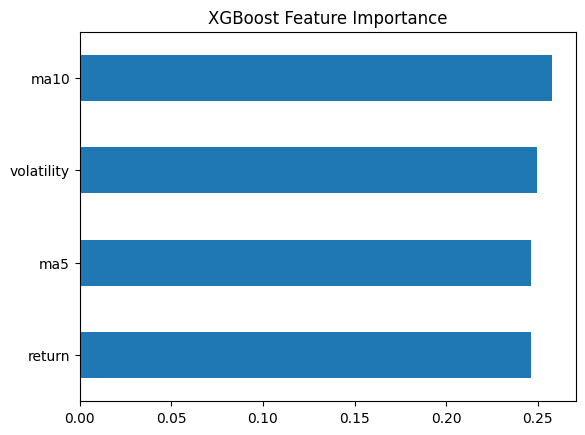


🚀 Running ML pipeline for ARKK
🔄 Fetching data for ARKK ...


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_27624\3201791648.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Liam Sydney\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:23:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:
                     Accuracy   ROC-AUC
KNN                  0.505415  0.485219
Random Forest        0.530686  0.476547
Naive Bayes          0.555957  0.473929
SVM                  0.465704  0.469751
Logistic Regression  0.534296  0.457483
XGBoost              0.498195  0.455420


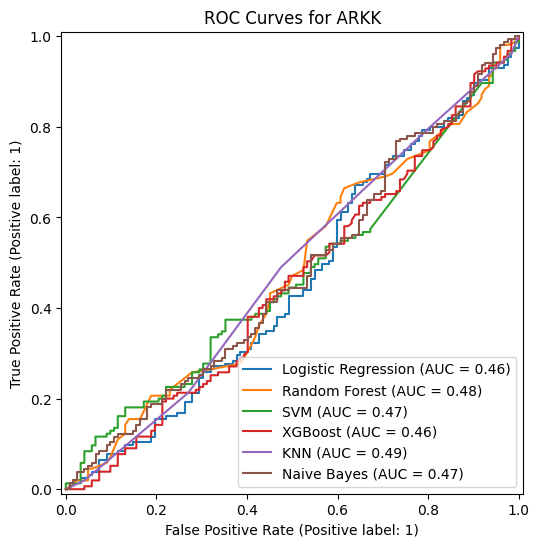


✅ Best Model: KNN

=== Classification Report for Best Model ===
              precision    recall  f1-score   support

        Down       0.45      0.52      0.48       122
          Up       0.57      0.49      0.53       155

    accuracy                           0.51       277
   macro avg       0.51      0.51      0.50       277
weighted avg       0.51      0.51      0.51       277



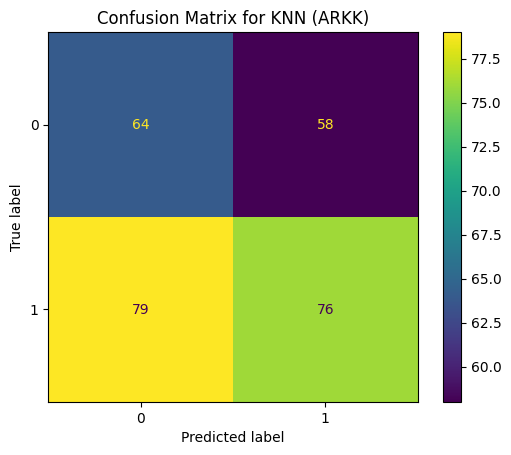


📈 Feature Importance:


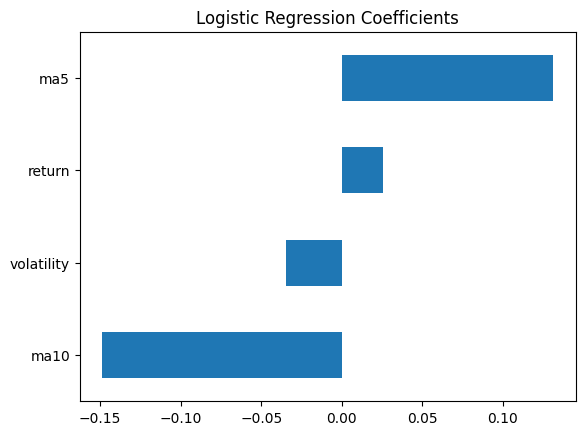

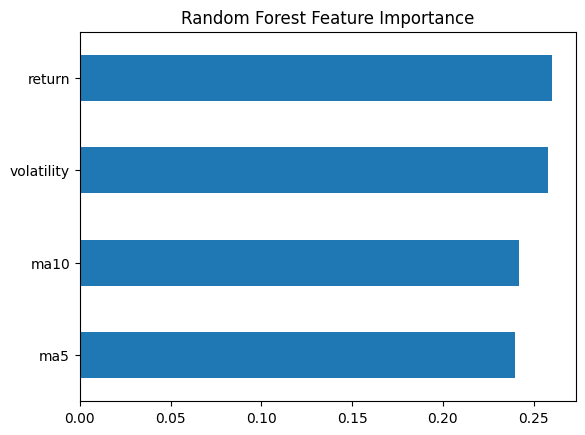

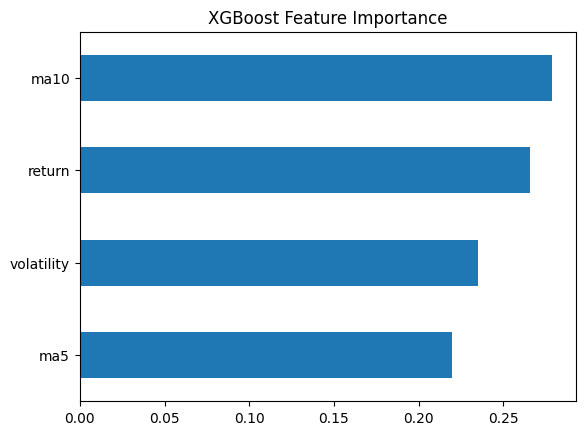


🚀 Running ML pipeline for NVDA
🔄 Fetching data for NVDA ...


C:\Users\Liam Sydney\AppData\Local\Temp\ipykernel_27624\3201791648.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date)['Close']
[*********************100%***********************]  1 of 1 completed
C:\Users\Liam Sydney\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:23:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Model Comparison:
                     Accuracy   ROC-AUC
Logistic Regression  0.563177  0.528451
XGBoost              0.519856  0.521837
Random Forest        0.505415  0.512336
SVM                  0.541516  0.511391
Naive Bayes          0.541516  0.504672
KNN                  0.541516  0.500000


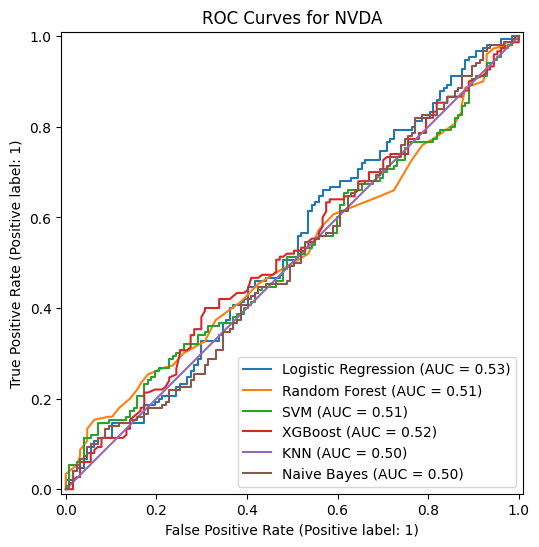


✅ Best Model: Logistic Regression

=== Classification Report for Best Model ===
              precision    recall  f1-score   support

        Down       0.69      0.09      0.15       127
          Up       0.56      0.97      0.71       150

    accuracy                           0.56       277
   macro avg       0.62      0.53      0.43       277
weighted avg       0.62      0.56      0.45       277



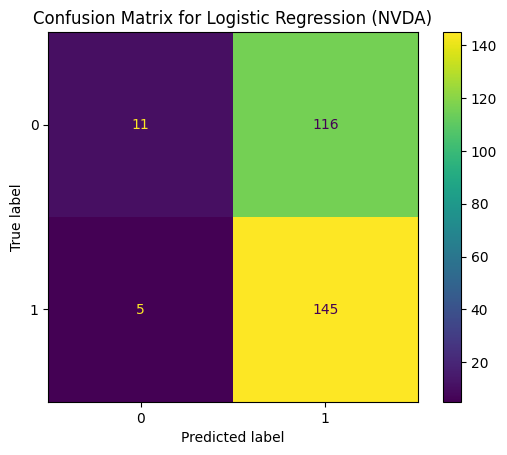


📈 Feature Importance:


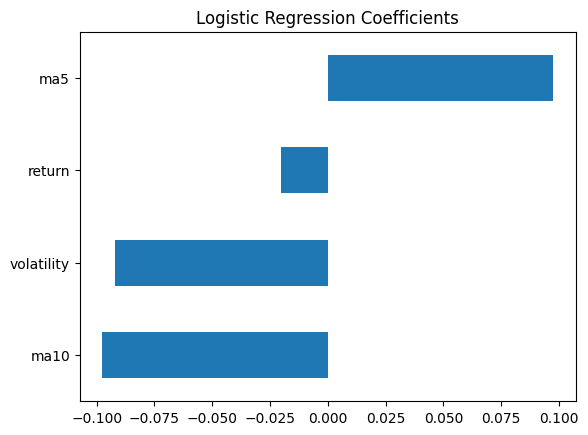

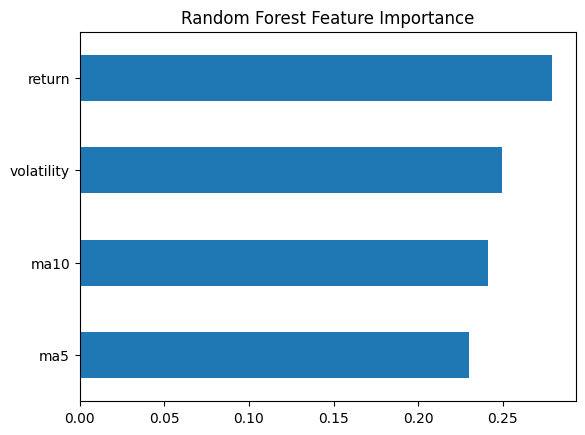

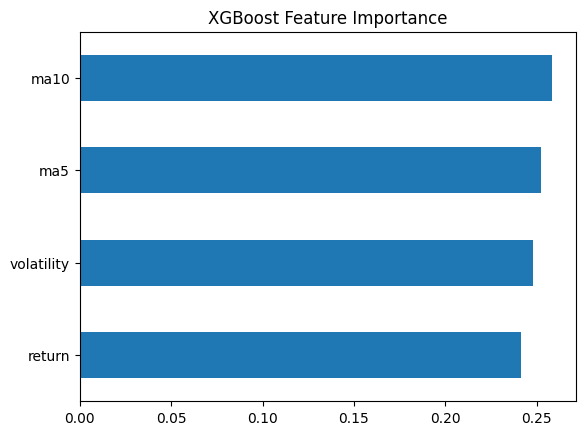


📊 Overall Summary Across Stocks:
  Ticker           Best Model  Best Accuracy  Best ROC-AUC
0   PLTR                  SVM          0.414         0.568
1   SHOP          Naive Bayes          0.545         0.538
2   ARKK                  KNN          0.505         0.485
3   NVDA  Logistic Regression          0.563         0.528


,Ticker,Best Model,Best Accuracy,Best ROC-AUC
0,PLTR,SVM,0.414,0.568
1,SHOP,Naive Bayes,0.545,0.538
3,NVDA,Logistic Regression,0.563,0.528
2,ARKK,KNN,0.505,0.485


In [11]:
stock_list = ["PLTR", "SHOP", "ARKK", "NVDA"]

summary_df = multi_stock_ml_comparison(stock_list)
summary_df

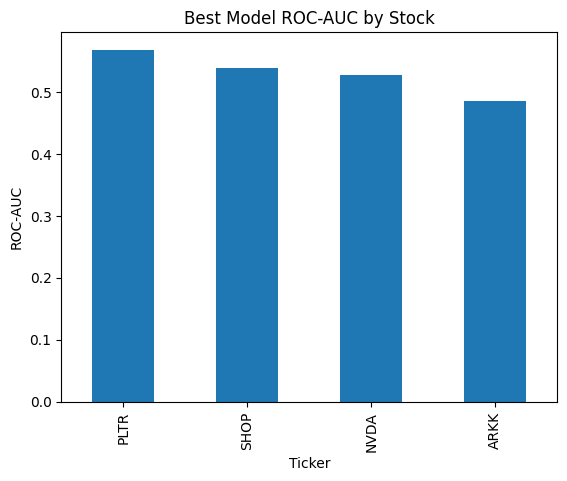

In [13]:
import matplotlib.pyplot as plt

summary_df.plot(
    x="Ticker",
    y="Best ROC-AUC",
    kind="bar",
    title="Best Model ROC-AUC by Stock",
    legend=False
)
plt.ylabel("ROC-AUC")
plt.show()